# The Annotated Transformer 보다 친절한 트랜스포머 튜토리얼

## 0. 데이터 가공
- 먼저, 튜토리얼에 사용하기 위해 [**AI Hub**](http://www.aihub.or.kr/)에서 [**한국어-영어 번역 말뭉치**](http://www.aihub.or.kr/aidata/87) 데이터 다운로드를 요청합니다.
- 다운로드 요청 후, 약 **2일** 내에 승인 결과가 메일로 전달된다고 합니다.
- 말뭉치는 기본적으로 **엑셀 파일**로 제공되지만, 실험의 편의를 위해 **CSV** 파일로 변환해 사용하도록 합니다.

_cf. 현재 AI Hub에서는 다양한 한영 번역 데이터셋을 구축해 총 **160만 쌍**의 데이터를 제공해주고 있지만, 모든 문장을 훈련시키기에는 데이터가 과도하므로 본 튜토리얼에서는 **구어체 데이터 1 & 2**만을 사용하도록 합니다._

In [2]:
import time
import pandas as pd

In [5]:
# 두 개 코퍼스 파일 CSV 포맷으로 변환 저장

xls_a = pd.read_excel('data/1_구어체(1).xlsx', index_col=None)
xls_b = pd.read_excel('data/1_구어체(2).xlsx', index_col=None)

xls_a.to_csv('data/spoken1.csv', encoding='utf-8', index=False)
xls_b.to_csv('data/spoken2.csv', encoding='utf-8', index=False)

/home/khkim/anaconda3/envs/torch/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


- 이제, **CSV**로 변환한 말뭉치 파일을 `pandas` 라이브러리를 이용해 읽어옵니다.
- 읽어온 파일의 각 행을 돌며, **한국어 문장**과 **영어 문장**을 각각의 리스트에 저장해줍니다.

In [6]:
# CSV로 변환한 말뭉치 파일 로드 및 합병

data_a = pd.read_csv('data/spoken1.csv', encoding='utf-8')
data_b = pd.read_csv('data/spoken2.csv', encoding='utf-8')

data = pd.concat([data_b, data_a], ignore_index=True)

In [8]:
# 합병된 데이터 프레임 확인

data

,SID,원문,번역문
0,200001,0 설정을 입력하고 안정될 때까지 5분 동안 기다린 후 OK 버튼을 길게 누르십시오.,"Enter into 0 setting, and wait for 5 minutes t..."
1,200002,0은 그들에게 아무것도 아니었지만 무는 숫자일 수가 없습니다.,The zero was nothing for them but nothing coul...
2,200003,"1,015버전에서 핫키 버그가 있습니다.","There is a Hotkey bug in the 1,015 version."
3,200004,"1,390점에서 1,440점을 득점한 사람은 재판을 위해 걸러집니다.","Individuals who got a score between 1,390 and ..."
4,200005,"1,400년보다 오래 전의 유적지에 있는 최초의 성당에서 숭배자들은 그것을 인지했을...","Indeed, worshippers at the very first cathedra..."
...,...,...,...
399995,199996,나는 먼저 청소기로 바닥을 밀었어요.,"First of all, I vacuumed the floor."
399996,199997,나는 먼저 팀 과제를 하고 놀러 갔어요.,I did the team assignment first and went out t...
399997,199998,나는 비 같은 멋진 연예인을 좋아해요.,I like cool entertainer like Rain.
399998,199999,나는 멋진 자연 경치를 보고 눈물을 흘렸어.,I cried seeing the amazing scenery.


- 두 코퍼스를 병합해 총 **400,000개**의 **병렬 문장 쌍**이 만들어진 것을 확인하였습니다!
- 이제 해당 데이터 프레임을 돌며, 한국어 문장과 영어 문장을 리스트에 각각 저장해줍니다.

In [9]:
# 한국어, 영어 데이터를 별개 리스트에 저장

kor_lines = []
eng_lines = []

for _, row in data.iterrows():
    _, kor, eng = row
    kor_lines.append(kor)
    eng_lines.append(eng)

**언어별 데이터**가 잘 저장되었는지 일부 데이터를 출력해 확인합니다.

In [10]:
for kor, eng in zip(kor_lines[:5], eng_lines[:5]):
    print(f'[KOR]: {kor}')
    print(f'[ENG]: {eng}\n')

[KOR]: 0 설정을 입력하고 안정될 때까지 5분 동안 기다린 후 OK 버튼을 길게 누르십시오.
[ENG]: Enter into 0 setting, and wait for 5 minutes to make it stable, then long-press OK button.

[KOR]: 0은 그들에게 아무것도 아니었지만 무는 숫자일 수가 없습니다.
[ENG]: The zero was nothing for them but nothing couldn't be a number.

[KOR]: 1,015버전에서 핫키 버그가 있습니다.
[ENG]: There is a Hotkey bug in the 1,015 version.

[KOR]: 1,390점에서 1,440점을 득점한 사람은 재판을 위해 걸러집니다.
[ENG]: Individuals who got a score between 1,390 and 1,440 are selected for a judge.

[KOR]: 1,400년보다 오래 전의 유적지에 있는 최초의 성당에서 숭배자들은 그것을 인지했을 것입니다.
[ENG]: Indeed, worshippers at the very first cathedral on this site, over 1,400 years ago, would have still recognized it.



**Tokenizers** 라이브러리를 학습시키기 위한 **훈련용 텍스트 파일**을 만들어줍니다.

In [11]:
# 한국어 토크나이저 훈련 데이터 제작

with open('train_korean.txt', 'w', encoding='utf-8') as f:
    for line in kor_lines:
        print(line, file=f)


# 영어 토크나이저 훈련 데이터 제작

with open('train_english.txt', 'w', encoding='utf-8') as f:
    for line in eng_lines:
        print(line, file=f)

## 1. BPE 토크나이저 학습
- 앞서 가공한 데이터들을 활용해 **BPE 토크나이저**를 학습시킵니다.
- 토크나이저를 학습시키기 앞서 프로젝트 전반에 사용될 변수 사전을 정의합니다.

In [12]:
params = {
    'batch_size': 64,
    'num_epoch': 15,
    'dropout': 0.1,
    'min_frequency': 3,

    'vocab_size': 20000,
    'num_layers': 6,
    'num_heads': 8,
    'hidden_dim': 512,
    'ffn_dim': 2048,
}

- 한국어와 영어 토크나이저를 **별도로 초기화해 훈련**시킵니다.

In [13]:
pip install tokenizers

Note: you may need to restart the kernel to use updated packages.


In [14]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer

# 한국어 토크나이저 초기화
kor_tokenizer = Tokenizer(BPE())


# 한국어 토크나이저 훈련
trainer = BpeTrainer(
    special_tokens=['[PAD]', '[SOS]', '[EOS]', '[UNK]'],
    vocab_size=params['vocab_size'],
    min_frequency=params['min_frequency']
)
kor_tokenizer.train(
    files=["train_korean.txt"],
    trainer=trainer)

In [15]:
# 영어 토크나이저 초기화
eng_tokenizer = Tokenizer(BPE())


# 영어 토크나이저 훈련
trainer = BpeTrainer(
    special_tokens=['[PAD]', '[SOS]', '[EOS]', '[UNK]'],
    vocab_size=params['vocab_size'],
    min_frequency=params['min_frequency']
)
eng_tokenizer.train(
    files=["train_english.txt"],
    trainer=trainer)

**패딩 옵션**과 **후처리 작업** 등에 사용될 **스페셜 토큰**들의 아이디를 저장해줍니다.

In [16]:
pad_idx = kor_tokenizer.token_to_id('[PAD]')
sos_idx = kor_tokenizer.token_to_id('[SOS]')
eos_idx = kor_tokenizer.token_to_id('[EOS]')

In [17]:
pad_idx, sos_idx, eos_idx

(0, 1, 2)

## 2. 훈련된 토크나이저로 토큰화 진행

Tokenizers의 `encode_batch` 함수를 활용해 각 데이터들에 대해 **토큰화 작업을 수행**해줍니다.

In [18]:
kor_encoded_data = kor_tokenizer.encode_batch(kor_lines)
eng_encoded_data = eng_tokenizer.encode_batch(eng_lines)

토큰화 작업이 잘 수행되었는지 기존 데이터와 비교해 확인합니다.

In [19]:
# 한국어 데이터 토큰화 작업 결과 출력

for origin, processed in zip(kor_lines[:3], kor_encoded_data[:3]):
    print(f'[Orig]: {origin}')
    print(f'[Proc]: {processed.tokens}\n')

[Orig]: 0 설정을 입력하고 안정될 때까지 5분 동안 기다린 후 OK 버튼을 길게 누르십시오.
[Proc]: ['0', ' ', '설정을 ', '입력', '하고 ', '안정', '될 때까지 ', '5', '분 동안 ', '기다', '린 ', '후 ', 'O', 'K', ' 버튼을 ', '길게 ', '누르', '십', '시', '오', '.']

[Orig]: 0은 그들에게 아무것도 아니었지만 무는 숫자일 수가 없습니다.
[Proc]: ['0', '은 ', '그들에게 ', '아무것도 ', '아니', '었지만 ', '무', '는 ', '숫자', '일', ' 수가 없', '습니다', '.']

[Orig]: 1,015버전에서 핫키 버그가 있습니다.
[Proc]: ['1,', '0', '15', '버전', '에서 ', '핫', '키', ' 버', '그', '가 있', '습니다', '.']



In [20]:
# 영어 데이터 토큰화 작업 결과 출력

for origin, processed in zip(eng_lines[:3], eng_encoded_data[:3]):
    print(f'[Orig]: {origin}')
    print(f'[Proc]: {processed.tokens}\n')

[Orig]: Enter into 0 setting, and wait for 5 minutes to make it stable, then long-press OK button.
[Proc]: ['En', 'ter ', 'into ', '0 ', 'sett', 'ing, and ', 'wait for ', '5 ', 'minutes to ', 'make it ', 'st', 'able', ', then ', 'long-', 'press ', 'O', 'K ', 'button', '.']

[Orig]: The zero was nothing for them but nothing couldn't be a number.
[Proc]: ['The ', 'zer', 'o ', 'was ', 'nothing ', 'for', ' them ', 'but ', 'nothing ', "couldn't ", 'be a ', 'number', '.']

[Orig]: There is a Hotkey bug in the 1,015 version.
[Proc]: ['There is a ', 'Hot', 'key ', 'bug ', 'in the ', '1,', '0', '15 ', 'vers', 'ion', '.']



## 3. 토큰화 결과에 후처리 로직 적용

- 이제 토큰화 작업이 수행된 결과에 **[PAD]** 토큰을 붙여줄 차례입니다.
- **[PAD]** 토큰은 모델이 입력으로 받는 **최대 길이** 보다 길이가 짧은 문장들에 한해 부여되는 토큰이므로,
- **최대 길이**로 설정할 적정 길이를 찾기 위해 각 언어 쌍의 평균 길이와 최대 길이를 계산합니다.

In [21]:
# 한국어 데이터 평균 및 최대 길이 계산

kor_len_max = max(len(line.tokens) for line in kor_encoded_data)
kor_len = 0

for line in kor_encoded_data:
    kor_len += len(line.tokens)
kor_len_avg = kor_len / len(kor_encoded_data)

kor_len_avg, kor_len_max

(11.6913875, 53)

In [22]:
# 영어 데이터 평균 및 최대 길이 계산

eng_len_max = max(len(line.tokens) for line in eng_encoded_data)
eng_len = 0

for line in eng_encoded_data:
    eng_len += len(line.tokens)
eng_len_avg = eng_len / len(eng_encoded_data)

eng_len_avg, eng_len_max

(10.749995, 65)

데이터셋 내 문장들이 그렇게 긴 편이 아니므로 **32**로 입력 값의 **최대 길이**로 정해줍니다.

In [23]:
params['max_len'] = 32

마지막으로 **[PAD]** 토큰을 붙여주는 `pad_sentence` 함수와

문장의 시작과 끝을 알리는 **[SOS]**, **[EOS]** 토큰을 붙여주는 후처리 함수 `postprocess`를 정의해줍니다.

In [24]:
def pad_sentence(input_ids):
    '''최대 길이보다 짧은 문장들에 [PAD] 토큰 부여'''

    num_pad = params['max_len'] - len(input_ids)
    input_ids.extend([pad_idx] * num_pad)
    return input_ids

In [25]:
def postprocess(input_ids):
    '''입력 문장에 [SOS] 토큰과 [EOS] 토큰 부여'''

    input_ids = pad_sentence(input_ids)

    input_ids = [sos_idx] + input_ids

    input_ids = input_ids[:params['max_len']]

    if pad_idx in input_ids:
        pad_start = input_ids.index(pad_idx)
        input_ids[pad_start] = eos_idx
    else:
        input_ids[-1] = eos_idx

    return input_ids

앞서 정의한 두 함수를 이용하면 결과 값이 다음과 같이 바뀝니다.

In [26]:
# 기본 토큰화 작업 결과

sent = '우리 진짜 별나대 그냥 내가 너무 좋아해 넌 그걸 너무 잘 알고 날 쥐락펴락해 나도 마찬가지인걸'

proc_sent = kor_tokenizer.encode(sent)
print(f'토큰화 결과: {proc_sent.tokens}')

토큰화 결과: ['우리 ', '진짜 ', '별', '나', '대 ', '그냥 ', '내가 너무 ', '좋아', '해 ', '넌 ', '그걸 ', '너무 ', '잘 ', '알고 ', '날 ', '쥐', '락', '펴', '락', '해 ', '나도 ', '마찬가지', '인', '걸']


In [27]:
# 토큰화 + 후처리 작업 결과

post_proc_sent = postprocess(proc_sent.ids)

print(f'후처리 결과: {post_proc_sent}\n')
print(f'후처리 해석: {kor_tokenizer.decode(post_proc_sent)}')

후처리 결과: [1, 2152, 4099, 944, 407, 2473, 3010, 13818, 2125, 2054, 3573, 4313, 2180, 2137, 6523, 2468, 1482, 698, 1859, 698, 2054, 2464, 5344, 1399, 218, 2, 0, 0, 0, 0, 0, 0]

후처리 해석: 우리  진짜  별 나 대  그냥  내가 너무  좋아 해  넌  그걸  너무  잘  알고  날  쥐 락 펴 락 해  나도  마찬가지 인 걸


이제 후처리 함수를 활용해 모든 데이터셋들에 대해 **후처리 작업을 진행**해줍니다.

In [28]:
kor_processed_data = [postprocess(data.ids) for data in kor_encoded_data]
eng_processed_data = [postprocess(data.ids) for data in eng_encoded_data]

## 4. 모든 데이터셋을 텐서형 데이터로 변환

- 전처리와 후처리를 모두 마친 데이터들을 `torch.Tensor`로 변환해줍니다.
- 변환 후, `DataLoader`를 활용해 데이터들을 **배치**로 만들어줍니다.

In [29]:
import torch

torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cuda:0"
# device = "cpu"

kor_tensors = [torch.LongTensor(line).to(device) for line in kor_processed_data]
eng_tensors = [torch.LongTensor(line).to(device) for line in eng_processed_data]

In [30]:
import torch.utils.data

In [31]:
src_iter = torch.utils.data.DataLoader(kor_tensors, batch_size=params['batch_size'])
tgt_iter = torch.utils.data.DataLoader(eng_tensors, batch_size=params['batch_size'])

배치 데이터가 잘 생성되었는지 출력을 통해 확인합니다.

## 5. Transformer 모델링

- 먼저 모델 구현에 필요한 라이브러리들을 모두 임포트합니다.
- 실험을 함에 있어 항상 실험의 **Reproducibility**를 보장하기 위해 Seed 설정을 해줍니다.

In [34]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(32)
torch.cuda.manual_seed(32)
torch.backends.cudnn.deterministic = True

## 5-1. (Masked) Multi-Head Attention 구현

## 2.1 Sub Layers
### Multi-Head Attention

![](img/mha.png)

In [35]:
class MultiHeadAttention(nn.Module):
    '''멀티 헤드 어텐션 레이어'''
    def __init__(self, params):
        super(MultiHeadAttention, self).__init__()
        assert params['hidden_dim'] % params['num_heads'] == 0, "hidden dimension must be divisible by the number of heads"
        self.num_heads = params['num_heads']
        self.attn_dim = params['hidden_dim'] // self.num_heads

        self.q_w = nn.Linear(params['hidden_dim'], self.num_heads * self.attn_dim)
        self.k_w = nn.Linear(params['hidden_dim'], self.num_heads * self.attn_dim)
        self.v_w = nn.Linear(params['hidden_dim'], self.num_heads * self.attn_dim)

        self.o_w = nn.Linear(self.num_heads * self.attn_dim, params['hidden_dim'])

    def forward(self, q, k, v, mask=None):
        " q, k, v = [배치 사이즈, 문장 길이, 은닉 차원] "

        batch_size = q.size(0)

        q = self.q_w(q).view(batch_size, -1, self.num_heads, self.attn_dim).transpose(1, 2)
        k = self.k_w(k).view(batch_size, -1, self.num_heads, self.attn_dim).transpose(1, 2)
        v = self.v_w(v).view(batch_size, -1, self.num_heads, self.attn_dim).transpose(1, 2)
        # q, k, v = [배치 사이즈, 헤드 갯수, 문장 길이, 어텐션 차원]

        attn = torch.matmul(q, k.transpose(-1, -2))
        # attn = [배치 사이즈, 헤드 갯수, 문장 길이, 문장 길이]

        if mask is not None:
            mask = mask.unsqueeze(1)
            attn.masked_fill(mask==0, -1e9)

        score = F.softmax(attn, dim=-1)
        # score = [배치 사이즈, 헤드 갯수, 문장 길이, 문장 길이]

        output = torch.matmul(score, v)
        # output = [배치 사이즈, 헤드 갯수, 문장 길이, 어텐션 차원]

        output = output.transpose(1, 2).contiguous()
        # output = [배치 사이즈, 문장 길이, 헤드 갯수, 어텐션 차원]

        output = output.view(batch_size, -1, self.num_heads * self.attn_dim)
        # output = [배치 사이즈, 문장 길이, 은닉 차원]

        output = self.o_w(output)
        # output = [배치 사이즈, 문장 길이, 은닉 차원]

        return output, score

Masked Multi Head Attention을 위한 Subsequent Mask를 생성해주어야 합니다.

In [36]:
def create_subsequent_mask(tgt):
    batch_size, tgt_len = tgt.size()

    subsequent_mask = torch.triu(torch.ones(tgt_len, tgt_len), diagonal=1).bool()
    # subsequent_mask = [타겟 문장 길이, 타겟 문장 길이]

    subsequent_mask = subsequent_mask.unsqueeze(0).repeat(batch_size, 1, 1).to(device)
    # subsquent_mask = [배치 사이즈, 타겟 문장 길이, 타겟 문장 길이]

    return subsequent_mask

사용 예는 아래와 같습니다.

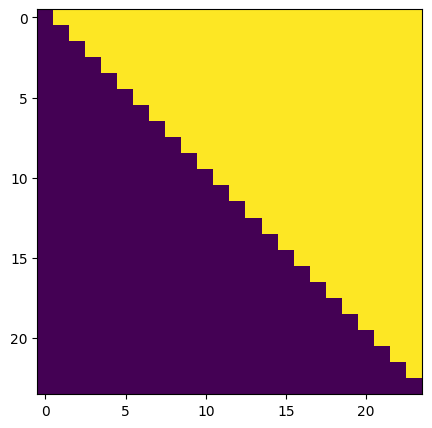

In [37]:
test_sent = '왜들 그리 다운돼있어? 뭐가 문제야 say something 분위기가 겁나 싸해'
test_tensor = kor_tokenizer.encode(test_sent)
test_tensor = torch.LongTensor(test_tensor.ids).to(device).unsqueeze(0)

plt.figure(figsize=(5,5))
plt.imshow(create_subsequent_mask(test_tensor).cpu()[0])

In [38]:
def create_src_mask(src):
    " source = [배치 사이즈, 소스 문장 길이] "

    src_len = src.size(1)

    src_mask = (src == pad_idx)
    # src_mask = [배치 사이즈, 소스 문장 길이]

    src_mask = src_mask.unsqueeze(1).repeat(1, src_len, 1)
    # src_mask = [배치 사이즈, 소스 문장 길이, 소스 문장 길이]

    return src_mask.to(device)


def create_tgt_mask(src, tgt):
    " src = [배치 사이즈, 소스 문장 길이] "
    " tgt = [배치 사이즈, 타겟 문장 길이] "

    batch_size, tgt_len = tgt.size()

    subsequent_mask = create_subsequent_mask(tgt)

    enc_dec_mask = (src == pad_idx)
    tgt_mask = (tgt == pad_idx)
    # src_mask = [배치 사이즈, 소스 문장 길이]
    # tgt_mask = [배치 사이즈, 타겟 문장 길이]

    enc_dec_mask = enc_dec_mask.unsqueeze(1).repeat(1, tgt_len, 1).to(device)
    tgt_mask = tgt_mask.unsqueeze(1).repeat(1, tgt_len, 1).to(device)
    # src_mask = [배치 사이즈, 타겟 문장 길이, 소스 문장 길이]
    # tgt_mask = [배치 사이즈, 타겟 문장 길이, 타겟 문장 길이]

    tgt_mask = tgt_mask | subsequent_mask

    return enc_dec_mask, tgt_mask

소스 문장의 마스크 생성 예는 아래와 같습니다.

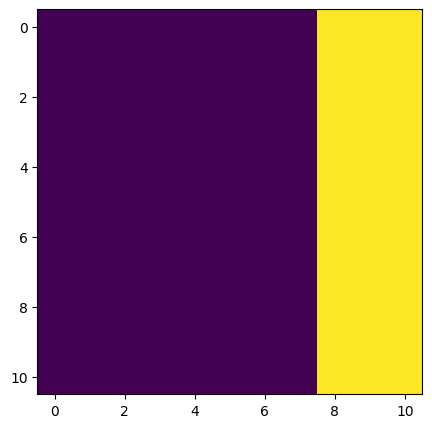

In [39]:
src = torch.tensor([[1, 2, 3, 4, 2, 11, 28, 7, 0, 0, 0]])
src_mask = create_src_mask(src)
plt.figure(figsize=(5,5))
plt.imshow(src_mask.cpu()[0])

타겟 문장의 마스크 생성 예는 아래와 같습니다.

In [40]:
tgt = torch.tensor([[1, 2, 3, 4, 2, 11, 28, 7, 99, 987, 1024, 0, 0]])
enc_dec_mask, tgt_mask = create_tgt_mask(src, tgt)

아래 그림은 타겟 문장이 소스 문장에 Attention을 취할 때 [PAD] 토큰이 마스킹 되는 예입니다.

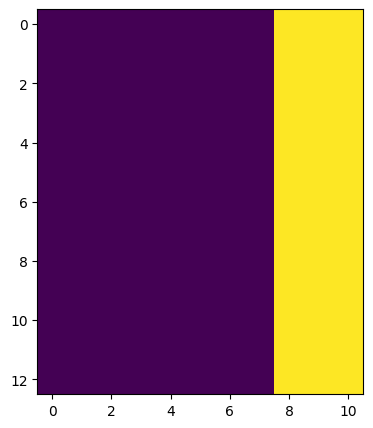

In [41]:
plt.figure(figsize=(5,5))
plt.imshow(enc_dec_mask.cpu()[0])

아래 예는 타겟 문장에서 Self-Attention 연산이 취해질 때 타임 스텝 상 뒤에 위치하는 토큰들과 [PAD] 토큰들이 마스킹 되는 예입니다.

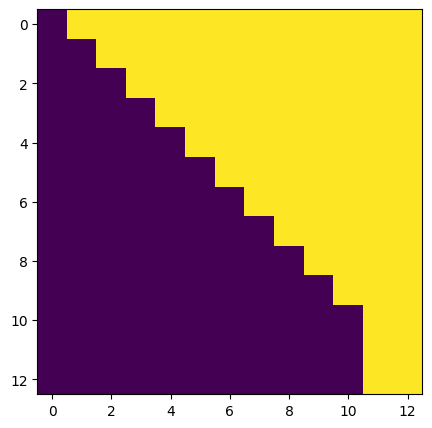

In [42]:
plt.figure(figsize=(5,5))
plt.imshow(tgt_mask.cpu()[0])

## 5-2. Position-wise Feed-Forward 네트워크 구현

![](img/positionwise.png)

In [43]:
## 5-2. Position-wise Feed-Forward 네트워크 구현
class PositionwiseFeedForward(nn.Module):
    '''포지션 와이즈 피드 포워드 레이어'''
    def __init__(self, parmas):
        super(PositionwiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(params['hidden_dim'], params['ffn_dim'])
        self.fc2 = nn.Linear(params['ffn_dim'], params['hidden_dim'])
        self.dropout = nn.Dropout(params['dropout'])

    def forward(self, x):
        " x = [배치 사이즈, 문장 길이, 은닉 차원] "

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

## 5-3. Positional Encoding 레이어 구현

![](img/pos.png)

In [44]:
class PositionalEncoding(nn.Module):
    def __init__(self, params):
        super(PositionalEncoding, self).__init__()
        sinusoid = np.array([pos / np.power(10000, 2 * i / params['hidden_dim'])
                            for pos in range(params['max_len']) for i in range(params['hidden_dim'])])
        # sinusoid = [문장 최대 길이 * 은닉 차원]

        sinusoid = sinusoid.reshape(params['max_len'], -1)
        # sinusoid = [문장 최대 길이, 은닉 차원]

        sinusoid[:, 0::2] = np.sin(sinusoid[:, 0::2])
        sinusoid[:, 1::2] = np.cos(sinusoid[:, 1::2])
        sinusoid = torch.FloatTensor(sinusoid).to(device)

        self.embedding = nn.Embedding.from_pretrained(sinusoid, freeze=True)

    def forward(self, x):
        " x = [배치 사이즈, 문장 길이] "

        pos = torch.arange(x.size(-1), dtype=torch.long).to(device)
        # pos = [배치 사이즈, 문장 길이]

        embed = self.embedding(pos)
        # embed = [배치 사이즈, 문장 길이, 은닉 차원]
        return embed

## 5-4. Transformer 인코더 부 구현

![](img/encoder.png)

In [45]:
class EncoderLayer(nn.Module):
    '''인코더 레이어'''
    def __init__(self, params):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(params)
        self.layer_norm1 = nn.LayerNorm(params['hidden_dim'])
        self.feed_forward = PositionwiseFeedForward(params)
        self.layer_norm2 = nn.LayerNorm(params['hidden_dim'])
        self.dropout = nn.Dropout(params['dropout'])

    def forward(self, x, src_mask):
        " x = [배치 사이즈, 문장 길이, 은닉 차원] "

        residual = x
        x, _ = self.self_attn(x, x, x, src_mask)
        x = self.dropout(x)
        x = residual + x
        x = self.layer_norm1(x)

        residual = x
        x = self.feed_forward(x)
        x = self.dropout(x)
        x = residual + x
        x = self.layer_norm2(x)

        return x


class Encoder(nn.Module):
    '''트랜스포머 인코더'''
    def __init__(self, params):
        super(Encoder, self).__init__()
        self.tok_embedding = nn.Embedding(params['vocab_size'], params['hidden_dim'], padding_idx=pad_idx)
        self.pos_embedding = PositionalEncoding(params)
        self.layers = nn.ModuleList([EncoderLayer(params) for _ in range(params['num_layers'])])

    def forward(self, src):
        " src = [배치 사이즈, 소스 문장 길이] "

        src_mask = create_src_mask(src)
        src = self.tok_embedding(src) + self.pos_embedding(src)

        for layer in self.layers:
            src = layer(src, src_mask)

        # src = [배치 사이즈, 소스 문장 길이, 은닉 차원]
        return src

## 5-5. Transformer 인코더 부 구현

![](img/decoder.png)

In [46]:
class DecoderLayer(nn.Module):
    '''디코더 레이어'''
    def __init__(self, params):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(params)
        self.layer_norm1 = nn.LayerNorm(params['hidden_dim'])

        self.enc_dec_attn = MultiHeadAttention(params)
        self.layer_norm2 = nn.LayerNorm(params['hidden_dim'])

        self.feed_forward = PositionwiseFeedForward(params)
        self.layer_norm3 = nn.LayerNorm(params['hidden_dim'])

        self.dropout = nn.Dropout(params['dropout'])

    def forward(self, x, tgt_mask, enc_output, src_mask):
        " x = [배치 사이즈, 문장 길이, 은닉 차원] "

        residual = x
        x, _ = self.self_attn(x, x, x, tgt_mask)
        x = self.dropout(x)
        x = residual + x
        x = self.layer_norm1(x)

        residual = x
        x, attn_map = self.enc_dec_attn(x, enc_output, enc_output, src_mask)
        x = self.dropout(x)
        x = residual + x
        x = self.layer_norm2(x)

        residual = x
        x = self.feed_forward(x)
        x = self.dropout(x)
        x = residual + x
        x = self.layer_norm3(x)

        return x, attn_map


class Decoder(nn.Module):
    '''트랜스포머 디코더'''
    def __init__(self, params):
        super(Decoder, self).__init__()
        self.tok_embedding = nn.Embedding(params['vocab_size'], params['hidden_dim'], padding_idx=pad_idx)
        self.pos_embedding = PositionalEncoding(params)
        self.layers = nn.ModuleList([DecoderLayer(params) for _ in range(params['num_layers'])])

    def forward(self, tgt, src, enc_out):
        " tgt = [배치 사이즈, 타겟 문장 길이] "

        src_mask, tgt_mask = create_tgt_mask(src, tgt)
        tgt = self.tok_embedding(tgt) + self.pos_embedding(tgt)

        for layer in self.layers:
            tgt, attn_map = layer(tgt, tgt_mask, enc_out, src_mask)

        tgt = torch.matmul(tgt, self.tok_embedding.weight.transpose(0, 1))
        # tgt = [배치 사이즈, 타겟 문장 길이, 은닉 차원]

        return tgt, attn_map

## 5-6. Transformer 구현

이제 앞서 정의한 레이어들을 토대로 **Transformer** 모델을 빌드해줍니다.

In [47]:
class Transformer(nn.Module):
    '''트랜스포머 네트워크'''
    def __init__(self, params):
        super(Transformer, self).__init__()
        self.encoder = Encoder(params)
        self.decoder = Decoder(params)

    def forward(self, src, tgt):
        " src = [배치 사이즈, 소스 문장 길이] "
        " tgt = [배치 사이즈, 타겟 문장 길이] "

        enc_out = self.encoder(src)
        dec_out, attn = self.decoder(tgt, src, enc_out)
        return dec_out, attn

    def count_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

Transformer 에서는 Adam Optimizer에 일부 스케줄 옵션을 적용해 사용하고 있습니다.

## 5-7. Transformer Optimizer 구현

![](img/optim.png)

In [48]:
class ScheduledOptim:
    '''스케줄 옵티마이저'''
    def __init__(self, optimizer, warmup_steps):
        self.init_lr = np.power(params['hidden_dim'], -0.5)
        self.optimizer = optimizer
        self.step_num = 0
        self.warmup_steps = warmup_steps

    def step(self):
        self.step_num += 1
        lr = self.init_lr * self.get_scale()

        for p in self.optimizer.param_groups:
            p['lr'] = lr

        self.optimizer.step()

    def zero_grad(self):
        self.optimizer.zero_grad()

    def get_scale(self):
        return np.min([
            np.power(self.step_num, -0.5),
            self.step_num * np.power(self.warmup_steps, -1.5)
        ])

## 6. 모델 학습

In [49]:
# 모델 정의

model = Transformer(params)
model.to(device)
print(f'The model has {model.count_params():,} trainable parameters')


# 로스 함수 정의

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
criterion.to(device)


# 옵티마이저 정의

optimizer = ScheduledOptim(
    optim.Adam(model.parameters(), betas=[0.9, 0.98], eps=1e-9),
    warmup_steps=4000
)

The model has 64,618,496 trainable parameters


In [50]:
params['num_epoch'] = 20

In [53]:
from tqdm import tqdm

In [60]:
# 훈련 로직

start_tic = time.time()

for epoch in tqdm(range(params['num_epoch']), desc="epoch"):
    model.train()
    epoch_loss = 0

    tic = time.time()
    for src, tgt in tqdm(zip(src_iter, tgt_iter), total=len(src_iter), desc="training", leave=False, mininterval=10):
        " src = [배치 사이즈, 소스 문장 길이] "
        " tgt = [배치 사이즈, 타겟 문장 길이] "

        optimizer.zero_grad()

        logits, _ = model(src, tgt[:, :-1])
        # logits = [배치 사이즈, 타겟 문장 길이, 은닉 차원]

        logits = logits.contiguous().view(-1, logits.size(-1))
        # logits = [(배치 사이즈 * 타겟 문장 길이) - 1, 은닉 차원]
        golds = tgt[:, 1:].contiguous().view(-1)
        # golds = [(배치 사이즈 * 타겟 문장 길이) - 1]

        loss = criterion(logits, golds)
        epoch_loss += loss.item()

        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), self.params.clip)
        optimizer.step()

    train_loss = epoch_loss / len(src_iter)
    toc = time.time()

    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Time: {toc - tic}')

    tic = time.time()
    # torch.save(model.state_dict(), f'/content/drive/MyDrive/transformer/epoch_{epoch}.pth')
    torch.save(model.state_dict(), f'./epoch_{epoch}.pth')
    toc = time.time()
    print(f"저장한 파일 이름 : ./epoch_{epoch}.pth  저장하는 데 걸린 시간 : {toc-tic}")

end_tic = time.time()
print("총 걸린 시간 : ", end_tic - start_tic)

training:  99%|█████████▊| 6168/6250 [11:13<00:08,  9.73it/s]
                                                             

Epoch: 01 | Train Loss: 2.502 | Time: 682.102511882782


epoch:   5%|▌         | 1/20 [11:24<3:36:50, 684.76s/it]

저장한 파일 이름 : ./epoch_0.pth  저장하는 데 걸린 시간 : 2.6553115844726562



training:  99%|█████████▉| 6218/6250 [11:34<00:04,  8.00it/s]
                                                             

Epoch: 02 | Train Loss: 2.302 | Time: 698.5236737728119


epoch:  10%|█         | 2/20 [23:05<3:28:19, 694.43s/it]

저장한 파일 이름 : ./epoch_1.pth  저장하는 데 걸린 시간 : 2.6784427165985107



training:  99%|█████████▉| 6186/6250 [12:14<00:06,  9.15it/s]
                                                             

Epoch: 03 | Train Loss: 2.259 | Time: 740.8336136341095


epoch:  15%|█▌        | 3/20 [35:29<3:23:06, 716.84s/it]

저장한 파일 이름 : ./epoch_2.pth  저장하는 데 걸린 시간 : 2.658512830734253



training:  99%|█████████▉| 6214/6250 [12:18<00:03,  9.27it/s]
                                                             

Epoch: 04 | Train Loss: 2.008 | Time: 742.1651451587677


epoch:  20%|██        | 4/20 [47:54<3:14:06, 727.89s/it]

저장한 파일 이름 : ./epoch_3.pth  저장하는 데 걸린 시간 : 2.6685421466827393



training:  99%|█████████▉| 6200/6250 [11:21<00:05,  8.42it/s]
                                                             

Epoch: 05 | Train Loss: 1.882 | Time: 687.1182317733765


epoch:  25%|██▌       | 5/20 [59:24<2:58:32, 714.15s/it]

저장한 파일 이름 : ./epoch_4.pth  저장하는 데 걸린 시간 : 2.65262770652771



training: 100%|█████████▉| 6224/6250 [12:38<00:03,  7.22it/s]
                                                             

Epoch: 06 | Train Loss: 3.072 | Time: 762.3579835891724


epoch:  30%|███       | 6/20 [1:12:09<2:50:40, 731.44s/it]

저장한 파일 이름 : ./epoch_5.pth  저장하는 데 걸린 시간 : 2.646153688430786



training: 100%|█████████▉| 6247/6250 [15:59<00:00,  9.04it/s]
                                                             

Epoch: 07 | Train Loss: 3.143 | Time: 960.0327560901642


epoch:  35%|███▌      | 7/20 [1:28:11<2:54:51, 807.04s/it]

저장한 파일 이름 : ./epoch_6.pth  저장하는 데 걸린 시간 : 2.6402688026428223



training:  99%|█████████▉| 6186/6250 [11:31<00:07,  8.71it/s]
                                                             

Epoch: 08 | Train Loss: 1.921 | Time: 698.7559933662415


epoch:  40%|████      | 8/20 [1:39:53<2:34:40, 773.41s/it]

저장한 파일 이름 : ./epoch_7.pth  저장하는 데 걸린 시간 : 2.6485018730163574



training:  99%|█████████▉| 6213/6250 [12:27<00:04,  8.06it/s]
                                                             

Epoch: 09 | Train Loss: 1.782 | Time: 752.0548079013824


epoch:  45%|████▌     | 9/20 [1:52:27<2:20:43, 767.57s/it]

저장한 파일 이름 : ./epoch_8.pth  저장하는 데 걸린 시간 : 2.662026882171631



training:  99%|█████████▉| 6194/6250 [12:15<00:07,  7.85it/s]
                                                             

Epoch: 10 | Train Loss: 1.353 | Time: 741.8992011547089


epoch:  50%|█████     | 10/20 [2:04:52<2:06:44, 760.47s/it]

저장한 파일 이름 : ./epoch_9.pth  저장하는 데 걸린 시간 : 2.6702630519866943



training:  99%|█████████▉| 6207/6250 [12:01<00:04,  9.19it/s]
                                                             

Epoch: 11 | Train Loss: 1.263 | Time: 726.3470296859741


epoch:  55%|█████▌    | 11/20 [2:17:01<1:52:37, 750.84s/it]

저장한 파일 이름 : ./epoch_10.pth  저장하는 데 걸린 시간 : 2.665971279144287



training:  99%|█████████▉| 6208/6250 [12:35<00:05,  8.09it/s]
                                                             

Epoch: 12 | Train Loss: 1.571 | Time: 759.4693460464478


epoch:  60%|██████    | 12/20 [2:29:43<1:40:34, 754.28s/it]

저장한 파일 이름 : ./epoch_11.pth  저장하는 데 걸린 시간 : 2.671729564666748



training:  99%|█████████▊| 6165/6250 [11:09<00:08,  9.78it/s]
                                                             

Epoch: 13 | Train Loss: 1.643 | Time: 677.8174583911896


epoch:  65%|██████▌   | 13/20 [2:41:04<1:25:23, 731.92s/it]

저장한 파일 이름 : ./epoch_12.pth  저장하는 데 걸린 시간 : 2.645444631576538



training: 100%|█████████▉| 6237/6250 [10:49<00:01,  9.64it/s]
                                                             

Epoch: 14 | Train Loss: 1.334 | Time: 651.3061213493347


epoch:  70%|███████   | 14/20 [2:51:58<1:10:50, 708.37s/it]

저장한 파일 이름 : ./epoch_13.pth  저장하는 데 걸린 시간 : 2.6476504802703857



training:  99%|█████████▉| 6216/6250 [10:44<00:03, 10.20it/s]
                                                             

Epoch: 15 | Train Loss: 1.063 | Time: 648.5670912265778


epoch:  75%|███████▌  | 15/20 [3:02:49<57:35, 691.14s/it]  

저장한 파일 이름 : ./epoch_14.pth  저장하는 데 걸린 시간 : 2.6358911991119385



training:  99%|█████████▉| 6218/6250 [10:57<00:03,  9.11it/s]
                                                             

Epoch: 16 | Train Loss: 1.136 | Time: 660.973176240921


epoch:  80%|████████  | 16/20 [3:13:52<45:31, 682.85s/it]

저장한 파일 이름 : ./epoch_15.pth  저장하는 데 걸린 시간 : 2.63864803314209



epoch:  80%|████████  | 16/20 [3:15:25<48:51, 732.82s/it]   


KeyboardInterrupt: 

In [61]:
# 모델의 state_dict 저장
torch.save(model.state_dict(), './final.pth')

In [ ]:
# Transformer 모델 인스턴스 생성 후에, state_dict 불러오기
state_dict = torch.load('./my_model.pth')

In [ ]:
# 모델에 state_dict 로드
model.load_state_dict(state_dict)

<All keys matched successfully>

In [62]:
# 모델을 평가 모드로 설정
model.eval()

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(20000, 512, padding_idx=0)
    (pos_embedding): PositionalEncoding(
      (embedding): Embedding(32, 512)
    )
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadAttention(
          (q_w): Linear(in_features=512, out_features=512, bias=True)
          (k_w): Linear(in_features=512, out_features=512, bias=True)
          (v_w): Linear(in_features=512, out_features=512, bias=True)
          (o_w): Linear(in_features=512, out_features=512, bias=True)
        )
        (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (feed_forward): PositionwiseFeedForward(
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (layer_norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, 

In [ ]:
type(model)

__main__.Transformer

## 7. 학습 결과 확인

이제 학습된 모델이 어느 정도 성능을 보이는지 확인해 볼 차례입니다.

In [ ]:
device = "cpu"

In [ ]:
model.to(device)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(20000, 512, padding_idx=0)
    (pos_embedding): PositionalEncoding(
      (embedding): Embedding(32, 512)
    )
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (q_w): Linear(in_features=512, out_features=512, bias=True)
          (k_w): Linear(in_features=512, out_features=512, bias=True)
          (v_w): Linear(in_features=512, out_features=512, bias=True)
          (o_w): Linear(in_features=512, out_features=512, bias=True)
        )
        (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (feed_forward): PositionwiseFeedForward(
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (layer_norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p

In [67]:
# 모델을 평가 모드로 설정
model.eval()

# 입력 문장
sent = '나는 행'

# 문장 토큰화
proc_sent = kor_tokenizer.encode(sent)

# 후처리
post_proc_sent = postprocess(proc_sent.ids)

# Tensor로 변환 및 배치 차원 추가
input_tensor = torch.LongTensor(post_proc_sent).to(device)
input_tensor = input_tensor.unsqueeze(0)

# 출력 문장 초기화
output_tensor = torch.LongTensor([1]).to(device).unsqueeze(0)  # <sos> 토큰 + 배치 차원 추가


# 디코딩
with torch.no_grad():
    for _ in range(1):  # 최대 길이
        logits, _ = model(input_tensor, output_tensor)
        next_token = logits.argmax(-1)[:,-1]
        output_tensor = torch.cat([output_tensor, next_token.unsqueeze(0)], dim=-1)
        if next_token.item() == 2:  # <eos> 토큰
            break

            
# 결과 디코딩
decoded_output = eng_tokenizer.decode(output_tensor.squeeze().tolist())
print(decoded_output)


In [ ]:
# 모델을 평가 모드로 설정
model.eval()

# 입력 문장
sent = '나'

# 문장 토큰화
proc_sent = kor_tokenizer.encode(sent)

# 후처리
post_proc_sent = postprocess(proc_sent.ids)

# Tensor로 변환 및 배치 차원 추가
input_tensor = torch.LongTensor(post_proc_sent).to(device)
input_tensor = input_tensor.unsqueeze(0)

# 출력 문장 초기화
output_tensor = torch.LongTensor([1]).to(device).unsqueeze(0)  # <sos> 토큰 + 배치 차원 추가

# 디코딩
with torch.no_grad():
    for _ in range(50):  # 최대 길이
        logits, _ = model(input_tensor, output_tensor)
        next_token = logits.argmax(-1)[:,-1]
        output_tensor = torch.cat([output_tensor, next_token.unsqueeze(-1)], dim=-1)
        if next_token.item() == 2:  # <eos> 토큰
            break

# 결과 디코딩
decoded_output = eng_tokenizer.decode(output_tensor.squeeze().tolist())
print(decoded_output)


s. s. s. s. s. s. s. s. s. s. s. s. s. s. s. s. s. s. s. s. s. s. s.


In [69]:
# ...
# 디코딩
with torch.no_grad():
    for _ in range(50):  # 최대 길이
        logits, _ = model(input_tensor, output_tensor)

        print("Logits: ", logits)  # 로짓 값 출력
        print("Argmax: ", logits.argmax(-1))  # 로짓의 argmax 결과 출력

        next_token = logits.argmax(-1)[:,-1]
        output_tensor = torch.cat([output_tensor, next_token.unsqueeze(0)], dim=-1)

        print("Output Tensor: ", output_tensor)  # 현재까지의 출력 텐서 값 출력

        if next_token.item() == 2:  # <eos> 토큰
            break

# 결과 디코딩
print("Decoding Output Tensor: ", output_tensor.squeeze().tolist())
decoded_output = eng_tokenizer.decode(output_tensor.squeeze().tolist())
print(decoded_output)


Logits:  tensor([[[-4.7171,  2.0480, 18.4399,  ..., -0.2575, -0.9721,  2.2967],
         [-4.9445,  2.1594, 18.9438,  ..., -0.2129, -0.9844,  2.3649]]],
       device='cuda:0')
Argmax:  tensor([[2, 2]], device='cuda:0')
Output Tensor:  tensor([[1, 2, 2]], device='cuda:0')
Decoding Output Tensor:  [1, 2, 2]



### 참고자료
- [The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html)
- [jadore801120/attention-is-all-you-need-pytorch](https://github.com/jadore801120/attention-is-all-you-need-pytorch)
- [tunz/transformer-pytorch](https://github.com/tunz/transformer-pytorch)
- [IgorSusmelj/pytorch-styleguide](https://github.com/IgorSusmelj/pytorch-styleguide)


### TODO: 더 추가할 수 있는 것들 !
- **Beam Search** 디코딩 추가
- **Label Smoothing** 기법 추가